In [51]:
# In case your input files are stored in your Google Drive, you can mount your drive executing this code cell
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import datetime
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant
from keras.layers import Conv1D, Dense, Dropout, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, InputLayer, LSTM, MaxPooling1D, Reshape
from keras.models import load_model, Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

#############################################
# Mandatory files to have, and their paths  #
# Check the README for more info            #
#############################################
DAILY_NEWS_PATH = "/content/drive/My Drive/NLP_DL/resources/daily_news.csv"  # path to the .csv file containing the daily news data
FOREX_PATH = "/content/drive/My Drive/NLP_DL/resources/forex_data.csv"  # path to the .csv file containing the (preprocessed) foreign exchange rate data
GLOVE_PATH = "/content/drive/My Drive/NLP_DL/resources/glove.6B.100d.txt"  # path to the .txt file containing the pre-trained word embedding model (Glove)

# Data loading, preprocessing

The preprocessing of the raw Forex data is implemented in a separate notebook file, which can also be found in the repository root folder as well. (**forex_preprocessing.ipynb**)

In this section, the following steps are done:
 - load the forex and daily news data
    - Daily news data: **2008-08-08** to **2016-07-01**
    - Forex data: **2010-11-14** to **2019-09-30**

- synchronize the two data source: for each daily news data, check if there is a forex data on the following day in the forex dataset -> if no, remove those days

- preprocess the daily news data:
    -  for each date, merge all the 25 daily headlines by appending them after each other
    - lemmatize and tokenize the data
    - transform the words in the sentences into word embeddings using the pre-trained Glove word embeddings (https://nlp.stanford.edu/projects/glove/)

- split the data into train, validation and tests datasets

Loading FOREX data

In [53]:
forex_df = pd.read_csv(FOREX_PATH)
print("Do we have data for each day? {}\n".format(all(forex_df)))
print("First date: {}".format(forex_df['Date'].iloc[0]))
print("Last date: {}\n\n".format(forex_df['Date'].iloc[-1]))
forex_df

Do we have data for each day? True

First date: 2010-11-14
Last date: 2019-09-30




,Date,BidQuote,AskQuote
0,2010-11-14,276.124167,276.274167
1,2010-11-15,276.518511,276.668511
2,2010-11-16,277.247576,277.397576
3,2010-11-17,277.254591,277.404591
4,2010-11-18,275.087612,275.237612
...,...,...,...
2721,2019-09-24,334.777242,334.893755
2722,2019-09-25,334.387243,334.492309
2723,2019-09-26,334.917537,335.031652
2724,2019-09-27,335.554946,335.670201


Loading daily news data

In [54]:
daily_news_df = pd.read_csv(DAILY_NEWS_PATH)
print("Do we have data for each day? {}\n".format(all(daily_news_df)))
print("First date: {}".format(daily_news_df['Date'].iloc[0]))
print("Last date: {}\n\n".format(daily_news_df['Date'].iloc[-1]))
daily_news_df

Do we have data for each day? True

First date: 2008-08-08
Last date: 2016-07-01




,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters 

Synchronizing daily news and forex data

In [55]:
def increase_date_by_one_day(series_element):
    """ Function to increase a date string by one day, using the datetime python package """
    year, month, day = series_element.split('-')  # split the string into year, month and day
    date = datetime.datetime(int(year), int(month), int(day))  # create datetime object
    next_date = date + datetime.timedelta(days=1)  # increase by one day

    # return the increased date in its original format
    return next_date.strftime("%Y") + "-" + next_date.strftime("%m") + "-" + next_date.strftime("%d")

def decrease_date_by_one_day(series_element):
    """ Function to decrease a date string by one day, using the datetime python package """
    year, month, day = series_element.split('-')  # split the string into year, month and day
    date = datetime.datetime(int(year), int(month), int(day))  # create datetime object
    next_date = date - datetime.timedelta(days=1)  # increase by one day

    # return the increased date in its original format
    return next_date.strftime("%Y") + "-" + next_date.strftime("%m") + "-" + next_date.strftime("%d")

daily_news_df['Date'] = daily_news_df['Date'].apply(func=increase_date_by_one_day)  # increase date by one day
merged_df = daily_news_df.merge(forex_df, how='outer', left_on='Date', right_on='Date') # synchronize the two datasets in this state
merged_df.sort_values('Date', axis=0, ascending=True, inplace=True)  # sort by date
merged_df.dropna(axis=0, how='any', inplace=True)  # if at a given date, there is no forex data or daily news data, remove those datapoints

merged_df['Date'] = merged_df['Date'].apply(func=decrease_date_by_one_day)  # decrease date by one day
merged_df.reset_index(drop=True, inplace=True)
merged_df

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,BidQuote,AskQuote
0,2010-11-15,Boris Johnson: George W. Bush cant fight for f...,"Taliban Commander: ""There are no al-Qa'ida fi...",Settlers torch West Bank olive trees - Israeli...,Maariyamma is likely to be killed by her child...,Ireland's young flee abroad as economic meltdo...,"""A two-year-old girl suffering from leukemia d...",Police in Egypt have been accused of beating a...,"""Hong Kong is officially the world's most wast...",Netanyahu presents security cabinet with Clint...,An Entire Village Flees Mexican Drug Violence,A Russian Banker And His 7-Man Team Beat Up A ...,Greece's Deficit Revised to Largest in EU as D...,'Unlawful sex': lovers sentenced to 100 lashes...,U.K. Politician Arrested for 'Glib' Twitter Th...,Hard questions about the new American handouts...,The Internet's new billion: New web users in c...,Interpol hunts two Israelis for Kosovo organ t...,UK Peer: Israel feeds global terrorism - A lon...,Mexico Arrests 12-Year-Old Cartel Hitman,TSA Caves On Molesting Pilots,Impending indictments in Hariri killing could ...,At least 32 killed in building collapse in Ind...,Shanghai high-rise on fire,Letter From Iran - \nSatellite TV channel co-o...,British wife of a millionaire businessman kill...,277.247576,277.397576
1,2010-11-16,"While you're getting groped by the TSA, here's...",Second squadron of 20 F-35s is an offer hard t...,R. Congresswoman Ros-Lehtinen opposes transfer...,"McDonald's, KFC, PepsiCo &amp; Mars Invited to...",Death sentence for migrant worker - Reddit! I ...,"Preparing for 2016 Olympics, Brazil invades sl...",Guantnamo Bay detainees to be paid millions in...,"Haitians riot, blame UN troops for cholera: Pr...","Mexican paper reports drug war, despite threats",My eyes are sweating: Hero dog who survived th...,Haiti rioters attack UN troops - Anti-UN riots...,More and more Irish people are leaving the str...,Mexico's $80M boom industry: Bulletproof cars,The toll in the collapse of a five-story resid...,How I Became An Oligarch - \nSpeech from Russi...,The difference between life and death in Haiti...,Pakistan vs. Haiti - Which Received More Aid? ...,Extradition of 'arms dealer' Viktor Bout goes ...,Bunga-Bunga Nation: Berlusconi's Italy Hurts W...,Sultan of the Muslim World | Modern Turkey bor...,While the US government is entertaining mind b...,UK government settles out of court with 16 Gua...,Google says China is breaking net laws: \nComp...,UK: London Metropolitan Police force closes do...,Ireland isn't working: Celtic Tiger becomes si...,277.254591,277.404591
2,2010-11-17,"Major spy scandal as Norway, Denmark, Finland,...",Freedom Of Speech 1 - Police 0. British police...,Evangelical Christians in Brazil have banned t...,UK Government comes out against net neutrality...,BBC picks up the TSA touching my junk story,Ireland: ANGRY protesters gathered at the home...,Tigers Near Extinction: The total number world...,Canada's Senate kills climate change bill\n,Madagascar military officers claim they have t...,Europe's corruption capital: How corruption in...,Australia wants to censor all images of smokin...,How China swallowed 15% of 'Net traffic for 18...,China's 'Me Generation' Sends Divorce Rate Soa...,Muslims set fire to at least 10 houses belongi...,"""Darfur, Zimbabwe, Burma, North Korea, anywher...",The suffering of Iraq's Christians - Some call...,Kim Jong-Un purging senior party and military ...,Sudan registers to vote to split country: Thou...,Get ready to kiss goodbye to net neutrality in...,Israeli retreat on Lebanon border may split vi...,Organs and bones were illegally harvested from...,World's newest nation would start almost from ...,Prime Minister of Madagascar vows to squash re...,Yemen's New Escort Service - Starved for reven...,"Rogue Trader Jerome Kerviel, sentenced to five...",275.087612,275.237612
3,2010-11-18,Remand request i

In [56]:
# Check the maximum difference between two dates
max_diff = 0
first_date = ""
second_date = ""
dates = merged_df['Date']

for i in range(len(dates)-1):
    # get current and next year, month, day
    current_year, current_month, current_day = dates.iloc[i].split('-')
    next_year, next_month, next_day = dates.iloc[i+1].split('-')

    # transform them into datetime object
    current_date = datetime.datetime(int(current_year), int(current_month), int(current_day))
    next_date = datetime.datetime(int(next_year), int(next_month), int(next_day))

    # check difference, save it if its higher than the already saved max difference
    date_diff = next_date - current_date
    date_diff = abs(float(date_diff.days))
    if (i == 0) or (date_diff > max_diff):
        max_diff = date_diff
        first_date = dates.iloc[i]
        second_date = dates.iloc[i+1]

print("Maximum missing days between two following data points: {} days\n".format(max_diff-1))  # Need to substract 1 to get the number of missing days from the "day difference"
print("Between: {} and {}\n\n".format(first_date, second_date))
print("First date of the merged dataset: {}\n".format(merged_df['Date'].iloc[0]))
print("Last date of the merged dataset: {}\n".format(merged_df['Date'].iloc[-1]))

Maximum missing days between two following data points: 5.0 days

Between: 2012-10-25 and 2012-10-31


First date of the merged dataset: 2010-11-15

Last date of the merged dataset: 2016-06-30



In [57]:
# Separate inputs (daily news data) and outputs (forex data) of our model
forex_data = merged_df[['BidQuote', 'AskQuote']]
daily_news_data = merged_df.drop(['Date', 'BidQuote', 'AskQuote'], axis=1)

forex_data  # average Bid and Ask Quote for a given day

,BidQuote,AskQuote
0,277.247576,277.397576
1,277.254591,277.404591
2,275.087612,275.237612
3,274.197428,274.347428
4,275.578741,275.728741
...,...,...
1124,317.277425,317.490940
1125,317.050972,317.174937
1126,316.879670,316.990106
1127,316.388392,316.502362


In [58]:
daily_news_data

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,Boris Johnson: George W. Bush cant fight for f...,"Taliban Commander: ""There are no al-Qa'ida fi...",Settlers torch West Bank olive trees - Israeli...,Maariyamma is likely to be killed by her child...,Ireland's young flee abroad as economic meltdo...,"""A two-year-old girl suffering from leukemia d...",Police in Egypt have been accused of beating a...,"""Hong Kong is officially the world's most wast...",Netanyahu presents security cabinet with Clint...,An Entire Village Flees Mexican Drug Violence,A Russian Banker And His 7-Man Team Beat Up A ...,Greece's Deficit Revised to Largest in EU as D...,'Unlawful sex': lovers sentenced to 100 lashes...,U.K. Politician Arrested for 'Glib' Twitter Th...,Hard questions about the new American handouts...,The Internet's new billion: New web users in c...,Interpol hunts two Israelis for Kosovo organ t...,UK Peer: Israel feeds global terrorism - A lon...,Mexico Arrests 12-Year-Old Cartel Hitman,TSA Caves On Molesting Pilots,Impending indictments in Hariri killing could ...,At least 32 killed in building collapse in Ind...,Shanghai high-rise on fire,Letter From Iran - \nSatellite TV channel co-o...,British wife of a millionaire businessman kill...
1,"While you're getting groped by the TSA, here's...",Second squadron of 20 F-35s is an offer hard t...,R. Congresswoman Ros-Lehtinen opposes transfer...,"McDonald's, KFC, PepsiCo &amp; Mars Invited to...",Death sentence for migrant worker - Reddit! I ...,"Preparing for 2016 Olympics, Brazil invades sl...",Guantnamo Bay detainees to be paid millions in...,"Haitians riot, blame UN troops for cholera: Pr...","Mexican paper reports drug war, despite threats",My eyes are sweating: Hero dog who survived th...,Haiti rioters attack UN troops - Anti-UN riots...,More and more Irish people are leaving the str...,Mexico's $80M boom industry: Bulletproof cars,The toll in the collapse of a five-story resid...,How I Became An Oligarch - \nSpeech from Russi...,The difference between life and death in Haiti...,Pakistan vs. Haiti - Which Received More Aid? ...,Extradition of 'arms dealer' Viktor Bout goes ...,Bunga-Bunga Nation: Berlusconi's Italy Hurts W...,Sultan of the Muslim World | Modern Turkey bor...,While the US government is entertaining mind b...,UK government settles out of court with 16 Gua...,Google says China is breaking net laws: \nComp...,UK: London Metropolitan Police force closes do...,Ireland isn't working: Celtic Tiger becomes si...
2,"Major spy scandal as Norway, Denmark, Finland,...",Freedom Of Speech 1 - Police 0. British police...,Evangelical Christians in Brazil have banned t...,UK Government comes out against net neutrality...,BBC picks up the TSA touching my junk story,Ireland: ANGRY protesters gathered at the home...,Tigers Near Extinction: The total number world...,Canada's Senate kills climate change bill\n,Madagascar military officers claim they have t...,Europe's corruption capital: How corruption in...,Australia wants to censor all images of smokin...,How China swallowed 15% of 'Net traffic for 18...,China's 'Me Generation' Sends Divorce Rate Soa...,Muslims set fire to at least 10 houses belongi...,"""Darfur, Zimbabwe, Burma, North Korea, anywher...",The suffering of Iraq's Christians - Some call...,Kim Jong-Un purging senior party and military ...,Sudan registers to vote to split country: Thou...,Get ready to kiss goodbye to net neutrality in...,Israeli retreat on Lebanon border may split vi...,Organs and bones were illegally harvested from...,World's newest nation would start almost from ...,Prime Minister of Madagascar vows to squash re...,Yemen's New Escort Service - Starved for reven...,"Rogue Trader Jerome Kerviel, sentenced to five..."
3,Remand request issued for WikiLeaks founder Ju...,Almost all borrowers in one of Indias largest ...,"13 dead, as strange disease spreads in Uganda:..

Separate train / validation / test data

In [59]:
VALID_SPLIT = 0.15
TEST_SPLIT = 0.1

nb_samples = daily_news_data.shape[0]
valid_size = int(nb_samples*(1-TEST_SPLIT-VALID_SPLIT))
test_size = int(nb_samples*(1-TEST_SPLIT))
X_train, Y_train = daily_news_data[:valid_size], forex_data[:valid_size]
X_valid, Y_valid = daily_news_data[valid_size:test_size], forex_data[valid_size:test_size]
X_test, Y_test = daily_news_data[test_size:], forex_data[test_size:]

print("X train shape: {}".format(X_train.shape))
print("X valid shape: {}".format(X_valid.shape))
print("X test shape: {}".format(X_test.shape))
print("Y train shape: {}".format(Y_train.shape))
print("Y valid shape: {}".format(Y_valid.shape))
print("Y test shape: {}".format(Y_test.shape))

X train shape: (846, 25)
X valid shape: (170, 25)
X test shape: (113, 25)
Y train shape: (846, 2)
Y valid shape: (170, 2)
Y test shape: (113, 2)


Prepare forex data (target values for regression): min-max scaling

In [0]:
y_train_scaler = MinMaxScaler().fit(Y_train)
Y_train = y_train_scaler.transform(Y_train)

y_valid_scaler = MinMaxScaler().fit(Y_valid)
Y_valid = y_valid_scaler.transform(Y_valid)

y_test_scaler = MinMaxScaler().fit(Y_test)
Y_test = y_test_scaler.transform(Y_test)

In [61]:
print(Y_train)
print("\n")
print(Y_valid)
print("\n")
print(Y_test)

[[0.23932076 0.2392677 ]
 [0.23943979 0.2393863 ]
 [0.20266878 0.20274926]
 ...
 [0.7681021  0.76703579]
 [0.75496188 0.75343368]
 [0.7305579  0.72873231]]


[[0.5992391  0.60147973]
 [0.62297615 0.62585461]
 [0.50803807 0.51007221]
 [0.46205627 0.46326435]
 [0.50326808 0.50627741]
 [0.42885302 0.43121767]
 [0.41950874 0.42205707]
 [0.42742663 0.43301605]
 [0.40423746 0.40593047]
 [0.31815848 0.31893864]
 [0.30988888 0.30934816]
 [0.42706391 0.42723716]
 [0.48664942 0.48724231]
 [0.41673953 0.41923279]
 [0.38107365 0.38246955]
 [0.50686005 0.51058485]
 [0.38604468 0.38985477]
 [0.33249388 0.3352116 ]
 [0.44383386 0.44604608]
 [0.34865854 0.35508775]
 [0.35064672 0.35738257]
 [0.30891617 0.31519011]
 [0.35333947 0.3546282 ]
 [0.23805678 0.24551485]
 [0.11152401 0.11377392]
 [0.15731508 0.1614876 ]
 [0.18052572 0.18351509]
 [0.15903172 0.16224849]
 [0.11105724 0.11208332]
 [0.14121927 0.14278733]
 [0.13501964 0.14429081]
 [0.08998789 0.10745438]
 [0.02264005 0.02310806]
 [0.06024144 0.06

Prepare daily news data (input values for regression): 
- merge the headlines into one for a given date
- lemmatize and tokenize the words
- use glove word embeddings to represent the words

In [62]:
trainheadlines = []
for row in range(0, len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,1:len(X_train.columns)]))

validheadlines = []
for row in range(0,len(X_valid.index)):
    validheadlines.append(' '.join(str(x) for x in X_valid.iloc[row,1:len(X_valid.columns)]))

testheadlines = []
for row in range(0,len(X_test.index)):
    testheadlines.append(' '.join(str(x) for x in X_test.iloc[row,1:len(X_test.columns)]))

print(len(trainheadlines))
print(len(validheadlines))
print(len(testheadlines))

846
170
113


In [0]:
nlp = English()

def filter_headlines(headlines):
    """ Function to transform headlines in a more understandable and cleaner form 
        Check example results one code cell below.
    """
    filtered_headlines = []

    for headline in headlines:
        headline = nlp(headline)  # read headline into spacy

        # Create list of word tokens
        token_list = []
        for token in headline:
            token_list.append(token.lemma_)  # use the lemmatized format of the words

        filtered_headline = ""

        for word in token_list:
            lexeme = nlp.vocab[word]
            if (lexeme.is_stop == False) and (len(word) > 1):  # take words only that are not stopwords and not single letters
                if word.startswith("b'") or word.startswith('b"'):  # parsed daily news often start with "b" letters due to the parsing: remove these
                    word = word[2:]
                filtered_headline = filtered_headline + " " + word

        filtered_headlines.append(filtered_headline)
    return filtered_headlines

# Transform train, validation and tests headlines
filtered_train_headlines = filter_headlines(trainheadlines)
filtered_valid_headlines = filter_headlines(validheadlines)
filtered_test_headlines = filter_headlines(testheadlines)

In [64]:
# Example: merged headlines before tranformation
trainheadlines[0]

'Taliban Commander:  "There are no al-Qa\'ida fighters in Afghanistan any more. I have fought in the south and in the east as well as here. In seven years of operations I have not seen a single al-Qa\'ida fighter. Not one." Settlers torch West Bank olive trees - Israeli settlers have torched hundreds of Palestinian olive trees in the occupied West Bank, in another sign that extremists are targeting a key product of the Palestinian economy. Maariyamma is likely to be killed by her children because they cannot afford her. She is just one of many old parents in a southern Indian state dying in this way. But no one blinks at these ritual murders. Ireland\'s young flee abroad as economic meltdown looms. "A two-year-old girl suffering from leukemia died while waiting for an urgent referral to an Israeli hospital. Since January 2009 a total of 33 patients have died while waiting to access hospitals outside Gaza." Police in Egypt have been accused of beating a teenager to death and dumping his

In [65]:
# Example: merged headlines after tranformation
filtered_train_headlines[0]

" Taliban Commander al Qa'ida fighter Afghanistan fight south east good seven year operation single al Qa'ida fighter Settlers torch West Bank olive tree Israeli settler torched Palestinian olive tree occupy West Bank sign extremist target key product Palestinian economy Maariyamma likely kill child afford old parent southern Indian state dye way blink ritual murder Ireland young flee abroad economic meltdown loom year old girl suffer leukemia die wait urgent referral Israeli hospital January 2009 total 33 patient die wait access hospital outside Gaza Police Egypt accuse beat teenager death dump body canal Hong Kong officially world wasteful city generate little 6.5 tonne rubbish year Netanyahu present security cabinet Clinton incentive 20 F-35 fighter plane security guarantee exchange 90-day West Bank build moratorium Entire Village Flees Mexican Drug Violence    Russian Banker 7-Man Team Beat Dutch Energy Executive Greece Deficit Revised Largest EU Debt Tops Italy Unlawful sex lover 

In [0]:
# Tokenization
MAX_NUM_WORDS = 30000  # maximum number of words to store in the corpus

# Initialize and fit a tokenizer on the train headlines
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(filtered_train_headlines)
word_index = tokenizer.word_index  # our vocabulary

# fit tokenizer on the datasets
sequences_train = tokenizer.texts_to_sequences(filtered_train_headlines)
sequences_valid = tokenizer.texts_to_sequences(filtered_valid_headlines)
sequences_test = tokenizer.texts_to_sequences(filtered_test_headlines)

# Note: due to this step, the words that are not present in the training dataset shall be left out from the valid/test datasets since we fitted the tokenizer on the train datasets only
# If the tokenizer was fitted on the whole dataset, that would have leaked information about the training data to the model, which is not acceptable
# This is in my opinion one weakness of my approach, the negative effects can only be reduced if we have as large training dataset as possible (so that no "new" words arrive to our modell when validating/testing it)

In [67]:
len(word_index)  # number of words in the vocabulary

19470

In [68]:
def determine_max_headline_length(sequences):
    """ Function to determine the merged headline with the maximum length"""
    max = 0
    for i, sequence in enumerate(sequences):
        if i == 0:
            max = len(sequence)
        else:
            if len(sequence) > max:
                max = len(sequence)
    return max

# We determine the merged headline with the maximum length, other headlines shall be padded to this size, so that we have a uniform input length for our model
MAX_SEQUENCE_LENGTH = determine_max_headline_length(sequences_train)

# Pad sequences to the same length
X_train = sequence.pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_valid = sequence.pad_sequences(sequences_valid, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(846, 381)
(170, 381)
(113, 381)


# Deep learning model

I have tried 3 different deep learning models for the task:
 - CNN + FC: 1D convolutional layers with a fully connected layer at the end of the architecture
 - LSTM + FC: Long-short term memory cells with a fully connected layer at the end of the architecture
 - CNN + LSTM + FC: 1D convolutional layers, connected to Long-short term memory cells with a fully connected layer at the end of the architecture

What is common in the 3 approaches, that each of them had an Embedding layer at the beginning of the Serial model, which transforms the input headline text into a word vector representation.

I used the pre-trained Glove word embeddings by the Stanford university (https://nlp.stanford.edu/projects/glove/), since my corpus does not really can effectively train an embedding layer due to the nature of the problem I want to solve:
 - headlines are merged, they had no connection before I merged them, yet the embedding layer would learn about their context

Therefore, I **froze** the Embedding layer, **it is not trained** during the training, basically serves the purpose of a "lookup table"

In [0]:
EMBEDDING_DIM = 100  # each word shall be represented by a glove vector of 1x100 shape

# open the file containing the pre-trained glove word embeddings, parse them into a dictionary
embeddings_index = {}
with open(GLOVE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)  # the number of words - basically the vocabulary size
# MAX_NUM_WORDS was the parameter that we sat, the maximum number of words that we wanted to save during the tokenization
# len(word_index): the actual number of words that we tokenized (+ 1 for "not a word")

# create the embedding matrix, and fill it with the transformed (glove embeddings) format of our tokenized corpus
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [70]:
print(embedding_matrix)
print("\n")
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.44233999  0.48431     0.37283999 ...  0.38253     0.47455999
  -0.6505    ]
 [-0.043959    0.18935999  0.66109997 ... -0.14168     0.92789
   0.59057999]
 ...
 [ 0.30467001 -0.29335001  0.82725    ... -0.40208    -0.19690999
  -0.46224999]
 [-0.2419     -0.14302    -0.68474001 ... -0.39947999  0.55575001
  -0.30636001]
 [ 0.48288    -0.14586    -0.051133   ...  0.35464001 -0.26153001
   0.29449999]]


(19471, 100)


**During the hyper parameter optimization**, I found that the 3 types of modells produce the same result in the terms of train/validation/test loss.

I analyze this in details in the attached document of my work (can be found in the repository).

Therefore, I decided to stick to the less complex model: **CNN + FC**

In [0]:
# Create the deep learning model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))  # Input layer
embedded_sequences = embedding_layer(sequence_input)  # Embedded layer

# Three 1D convolutional layers with Maxpooling and a GlobalMaxpooling at the end
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)


# Fully connected layer with droputs
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(2, activation='sigmoid')(x)  # output layer with two neurons, as our target variable has also two values (average Bid and Ask Quote for a given)
model = Model(sequence_input, preds)

# Use Adam as optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='mean_squared_error',
              optimizer=opt)

In [72]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 381)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 381, 100)          1947100   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 377, 128)          64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 71, 128)           82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 10, 128)           8204

In [73]:
# Use callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath='best_model.h5', verbose=1, save_best_only=True)

# Train
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=300,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[es, mc])

Train on 846 samples, validate on 170 samples
Epoch 1/300
846/846 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0557

Epoch 00001: val_loss improved from inf to 0.05570, saving model to best_model.h5
Epoch 2/300
846/846 [==============================] - 0s 163us/step - loss: 0.0612 - val_loss: 0.0576

Epoch 00002: val_loss did not improve from 0.05570
Epoch 3/300
846/846 [==============================] - 0s 125us/step - loss: 0.0601 - val_loss: 0.0584

Epoch 00003: val_loss did not improve from 0.05570
Epoch 4/300
846/846 [==============================] - 0s 113us/step - loss: 0.0591 - val_loss: 0.0589

Epoch 00004: val_loss did not improve from 0.05570
Epoch 5/300
846/846 [==============================] - 0s 110us/step - loss: 0.0587 - val_loss: 0.0571

Epoch 00005: val_loss did not improve from 0.05570
Epoch 6/300
846/846 [==============================] - 0s 99us/step - loss: 0.0578 - val_loss: 0.0583

Epoch 00006: val_loss did not improve from 0.05

In [74]:
# Test
saved_model = load_model('best_model.h5')
score = saved_model.evaluate(X_test, Y_test, batch_size=8)
score

113/113 [==============================] - 0s 2ms/step


0.05787844286687606

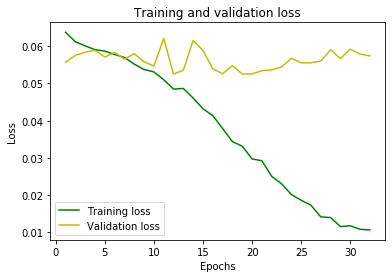

In [75]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()